#### Imports

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

import wrangle as w
import explore as e
import model as m

import warnings
warnings.filterwarnings('ignore')

# Wrangle

#### Acquire:
- Data was acquired from Kaggle
Nulls - Dropped 393 nulls

In [2]:
# If running this notebook for the first time, combining and creating new csv. Otherwise it is just reading the existing csv in.
df = w.get_airline_data()

# Creating dummy columns that can be use during modeling stage. 
df = w.prep_airline(df)

# Splitting into train, validate, and test BEFORE exploration phase! Allons-y ('let's go')
train, validate, test = w.split_function(df, 'satisfaction')

Found CSV!
   og_df:  (129487, 30)
   Train:  (77691, 30)
Validate:  (25898, 30)
    Test:  (25898, 30)


# Exploration Phase

**Target Variable is ***satisfaction*****

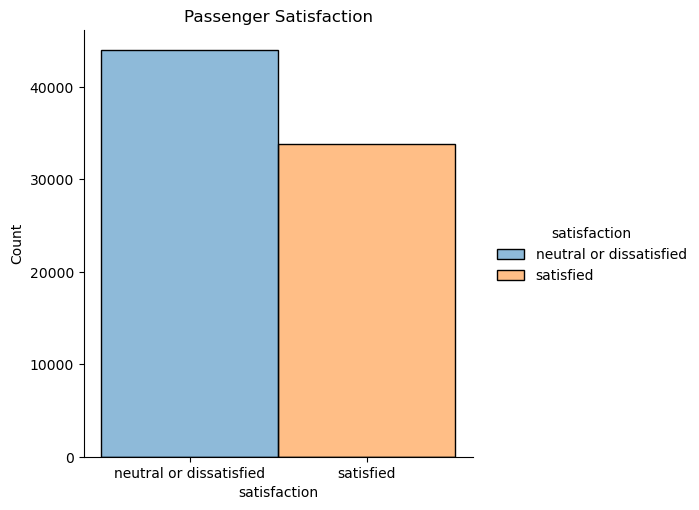

In [3]:
sns.displot(data=train, x='satisfaction', hue='satisfaction')
plt.title('Passenger Satisfaction')
plt.show()

#### Does flight duration impact passenger satisfaction?
- My initial thoughts are that flights with longer durations result in less passenger satisfaction.

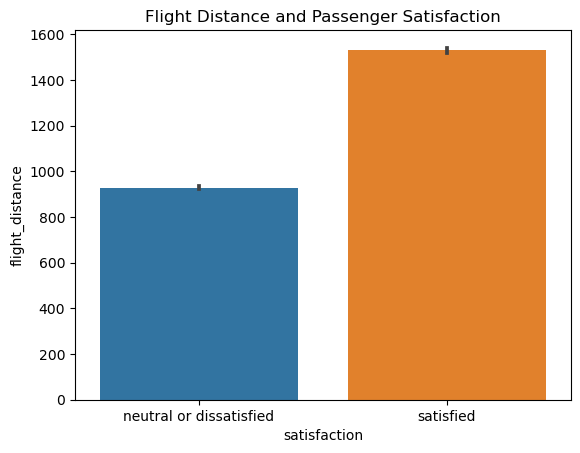

In [4]:
sns.barplot(data=train, x='satisfaction', y='flight_distance')
plt.title('Flight Distance and Passenger Satisfaction')
plt.show()

$H_0$: Mean flight distance of dissatisfied passengers <= Mean flight distance of all passengers  
$H_a$: Mean flight distance of dissatisfied passengers > Mean flight distance of all passengers

In [5]:
e.get_distance_satisfaction_ttest(train)

t = 55.43
p = 0.0
We reject the hypothesis


#### Takeaway:
- The mean flight distance for dissatisfied passengers is higher than the mean flight distance of all passengers
- Stats test showed that this is statistically significant
- Flight distance is a key driver for passenger satisfaction
- I did not expect this outcome. I initially hypothesized that longer duration flights would cause passengers to be less comfortable resulting in less passenger satisfaction.

#### Does gender impact passenger satisfaction?

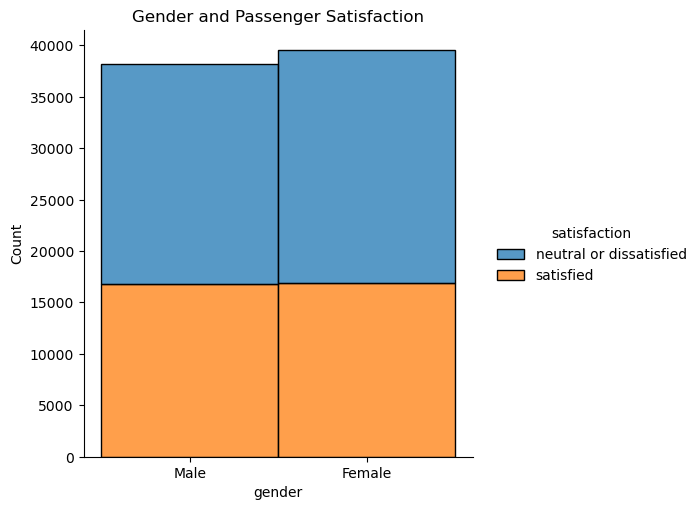

In [6]:
sns.displot(data=train, x='gender', hue='satisfaction', multiple='stack')
plt.title('Gender and Passenger Satisfaction')
plt.show()

$H_0$: There is **no** association between passenger satisfaction and gender  
$H_a$: There is association between passenger satisfaction and gender

In [7]:
e.get_chi2_results(train,'satisfaction', 'gender')

chi^2 = 14.4069
p.    = 0.0001
We reject the null hypothesis


gender,Female,Male
satisfaction,,
neutral or dissatisfied,22615,21320
satisfied,16911,16845


#### Takeaway:
- Although visually gender doesn't appear to be significant, statistical significance shows that females are more dissatisfied than males.

#### Does customer type (loyal vs disloyal) impact type of travel (business vs personal)?

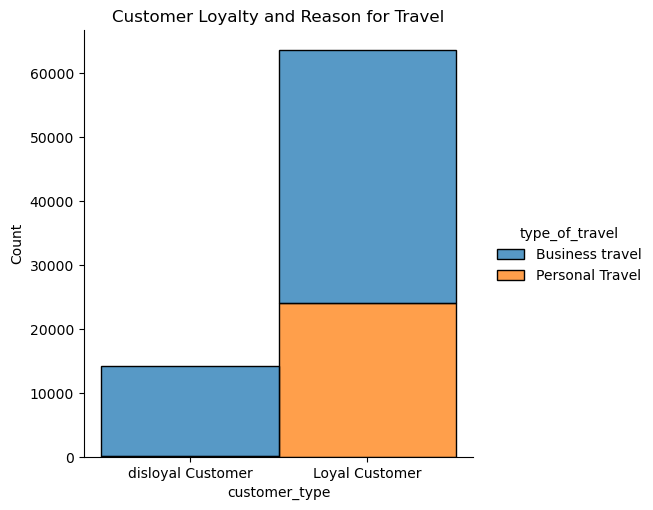

In [8]:
sns.displot(data=train, x='customer_type', hue='type_of_travel', multiple='stack')
plt.title('Customer Loyalty and Reason for Travel')
plt.show()

$H_0$: There is **no** association between type of travel(personal vs business) and customer type(loyal vs disloyal)  
$H_a$: There is association between type of travel(personal vs business) and customer type(loyal vs disloyal)

In [9]:
e.get_chi2_results(train, 'type_of_travel', 'customer_type')

chi^2 = 7389.8030
p.    = 0.0000
We reject the null hypothesis


customer_type,Loyal Customer,disloyal Customer
type_of_travel,,
Business travel,39491,14023
Personal Travel,24057,120


#### Takeaways:
- Disloyal customers overwhelmingly travel for business purposes.
- Loyal customers primarily travel for business purposes but make up the bulk of personal travelers (99.5%).
    - **Will utilize this metric in the next question**


#### Does type of travel impact passenger satisfaction?

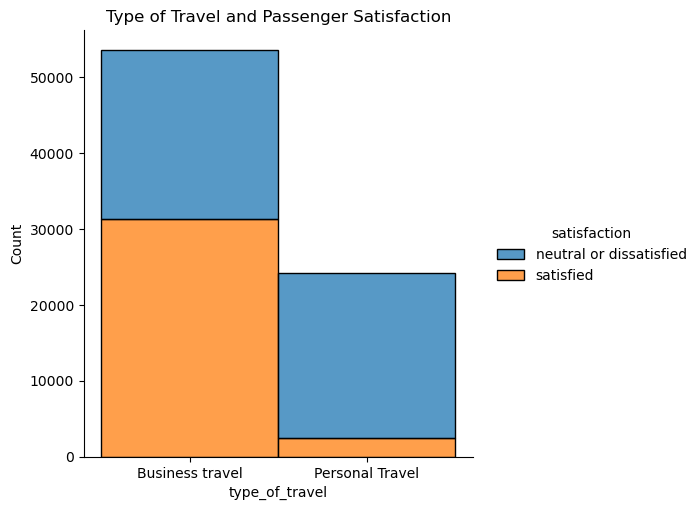

In [10]:
sns.displot(data=train, x='type_of_travel', hue='satisfaction', multiple='stack')
plt.title('Type of Travel and Passenger Satisfaction')
plt.show()

$H_0$: There is **no** association between type of travel(personal vs business) and passenger satisfaction  
$H_a$: There is association between type of travel(personal vs business) and passenger satisfaction

In [11]:
e.get_chi2_results(train, 'satisfaction', 'type_of_travel')

chi^2 = 15696.3434
p.    = 0.0000
We reject the null hypothesis


type_of_travel,Business travel,Personal Travel
satisfaction,,
neutral or dissatisfied,22248,21687
satisfied,31266,2490


#### Takeaways:
- As stated in the previous question, 99.5% of personal travelers are loyal passengers
- **90%** of Loyal customers who are traveling for personal purposes are dissatisfied. 24,177 travelers in this category.

#### Does customer loyalty impact satisfaction?

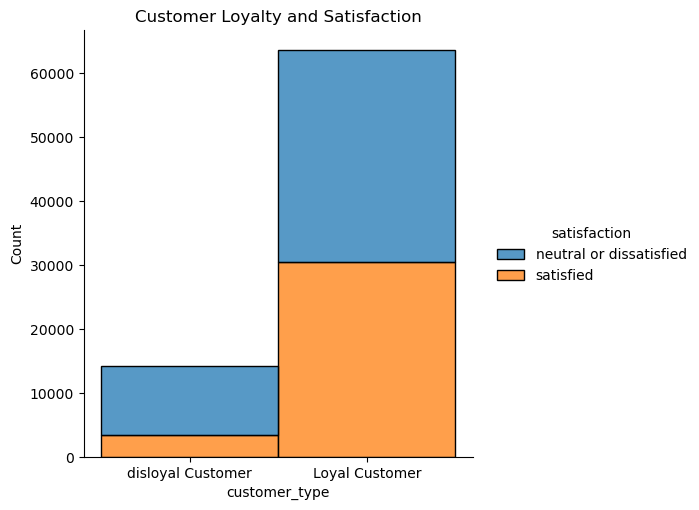

In [12]:
sns.displot(data=train, x='customer_type', hue='satisfaction', multiple='stack')
plt.title('Customer Loyalty and Satisfaction')
plt.show()

$H_0$: There is **no** association between customer type(loyal vs disloyal) and passenger satisfaction  
$H_a$: There is association between customer type(loyal vs disloyal) and passenger satisfaction 

In [13]:
e.get_chi2_results(train, 'satisfaction', 'customer_type')

chi^2 = 2747.3562
p.    = 0.0000
We reject the null hypothesis


customer_type,Loyal Customer,disloyal Customer
satisfaction,,
neutral or dissatisfied,33142,10793
satisfied,30406,3350


#### Takeaway:
- 48% of loyal customers are satisfied. 24% of disloyal customers are satisfied

## Exploration Summary:
- Passengers with shorter flights are dissatisfied at higher rates than customers who have longer flights
- Females are slightly more dissatisfied than males
- Loyal passengers make up 99.5% of the personal travel category
- 90% of loyal passengers who travel for personal reasons are dissatisfied
- Overall, 48% of loyal passengers are satisfied and 24% of disloyal passengers are satisfied

# Modeling

In [14]:
X_train, X_validate, X_test, y_train, y_validate, y_test = m.Xy_train_val_test(train, validate, test, 'satisfaction_satisfied')

Baseline Accuracy: 56.55%


In [15]:
X_train_scaled, X_validate_scaled, X_test_scaled = m.scaled_df(X_train, X_validate, X_test)

### KNN

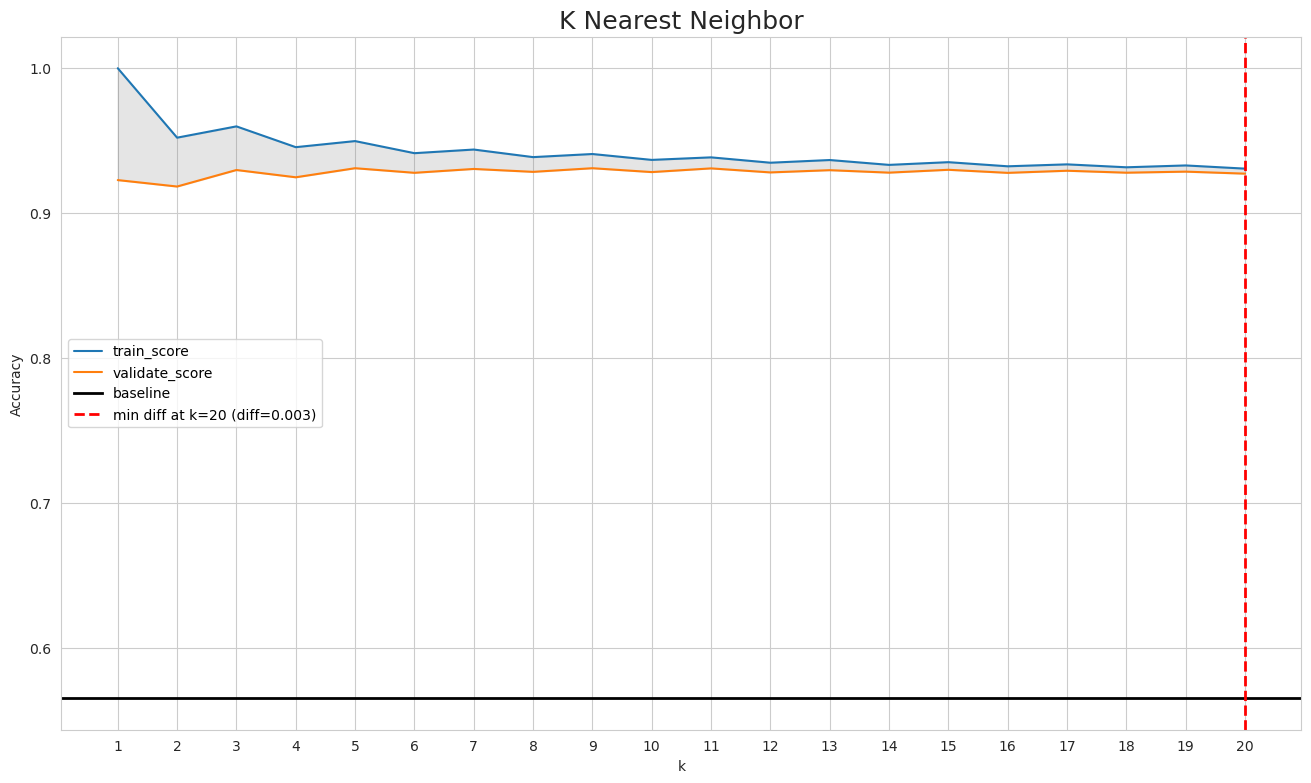

,k,train_score,validate_score,diff_score
10,11,0.938526,0.930921,0.007604


In [16]:
m.k_nearest2(X_train_scaled, y_train, X_validate_scaled, y_validate)[10:11]

#### KNN Model Takeaway:
- KNN with K=11 is the best performing KNN model
- Train accuracy = 93.85%
- Validate accuracy = 93.09%

### Decision Tree

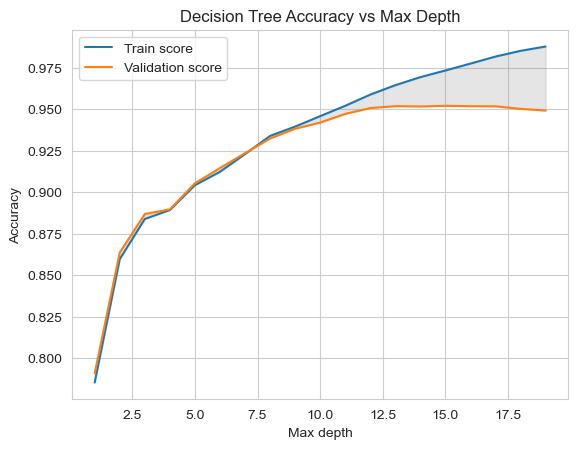

,max_depth,train_acc,val_acc,score_diff
11,12,0.958837,0.95073,0.008107


In [17]:
m.decision_tree(X_train_scaled, X_validate_scaled, y_train, y_validate)[11:12]

#### Decision Tree Model Takeaway:
- Decision Tree with max depth 12 is the best performing Decision Tree model
- Train accuracy = 95.88%
- Validate accuracy = 95.07%

### Random Forest

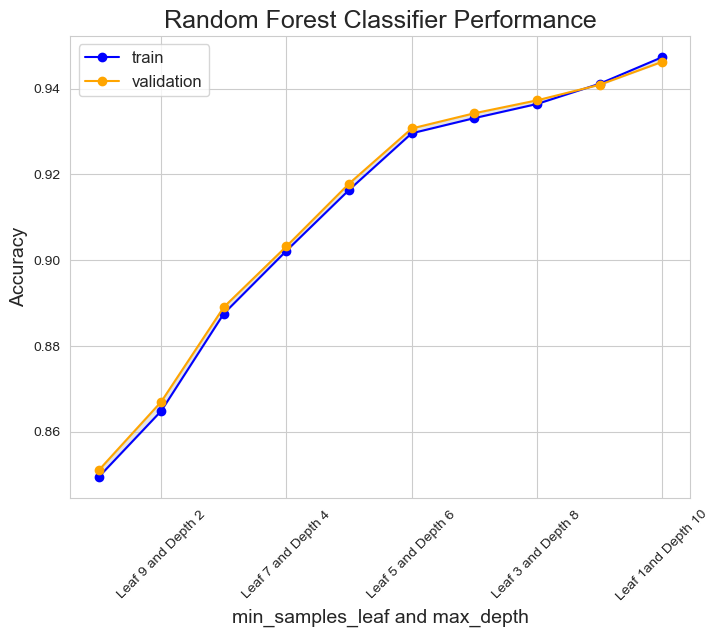

,min_samples_leaf,max_depth,train_score,validate_score,diff_score
0,1,10,0.947368,0.946289,0.001079


In [18]:
m.random_forest_scores(X_train_scaled, y_train, X_validate_scaled, y_validate)[0:1]

#### Random Forest Model Takeaway:
- Random Forest with min leaf samples = 1 and max depth = 10 is the best performing Random Forest model
- Train accuracy = 94.73%
- Validate accuracy = 94.62%

### Logistic Regression

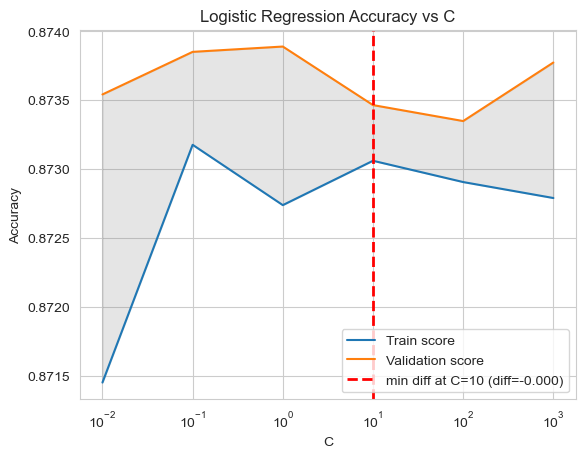

,C,train_score,validate_score,diff_score
1,0.1,0.873177,0.873851,-0.000674


In [19]:
m.plot_logistic_regression(X_train_scaled, X_validate_scaled, y_train, y_validate)[1:2]

#### Logistic Regression Model Takeaway:
- Logistic Regresssion with C = 0.1 is the best performing Logistic Regression model
- Train accuracy = 87.31%
- Validate accuracy = 87.38%

## Best Model

## Modeling Takeaways:
- one
- two
- three